In [3]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from scipy.stats import (
    wasserstein_distance,
    entropy,
    pearsonr
)

In [4]:
df = pd.read_csv('../../shared_data/processed/merged_data.csv', low_memory=False)
TASKS_WITH_TEXT = [
    'intimacy', 
    'politeness', 
    'offensiveness',
    'diaz',
    'dices-350'
]

df_text = df[df['task'].isin(TASKS_WITH_TEXT)].copy()

In [5]:
# computed from eval results in paper_results.ipynb
mean_score_seeds_dict = {
    ('Intimacy', '+Attributes (FTed)'): 701702170,
    ('Intimacy', '+ID (FTed)'): 370276791,
    ('Intimacy', '+ID+Attributes (FTed)'): 124600042,
    ('Intimacy', 'Best Zero-Shot'): 1885444771,
    ('Intimacy', 'Content Only (FTed)'): 185007946,
    ('Offensiveness', '+Attributes (FTed)'): 370276791,
    ('Offensiveness', '+ID (FTed)'): 1885444771,
    ('Offensiveness', '+ID+Attributes (FTed)'): 277728153,
    ('Offensiveness', 'Best Zero-Shot'): 224600032,
    ('Offensiveness', 'Content Only (FTed)'): 277728153,
    ('Politeness', '+Attributes (FTed)'): 277728153,
    ('Politeness', '+ID (FTed)'): 799443590,
    ('Politeness', '+ID+Attributes (FTed)'): 2454110510,
    ('Politeness', 'Best Zero-Shot'): 2454110510,
    ('Politeness', 'Content Only (FTed)'): 873469724,
    ('Safety', '+Attributes (FTed)'): 824411996,
    ('Safety', '+ID (FTed)'): 224600032,
    ('Safety', '+ID+Attributes (FTed)'): 1294938046,
    ('Safety', 'Best Zero-Shot'): 1506676066,
    ('Safety', 'Content Only (FTed)'): 799443590,
    ('Sentiment', '+Attributes (FTed)'): 1294938046,
    ('Sentiment', '+ID (FTed)'): 2969282657,
    ('Sentiment', '+ID+Attributes (FTed)'): 1294938046,
    ('Sentiment', 'Best Zero-Shot'): 2969282657,
    ('Sentiment', 'Content Only (FTed)'): 1847855308
}

best_lrs = {
        'diaz': ('3e-05','6e-05','6e-05'),
        'offensiveness': ('3e-05','8e-05','8e-05'),
        'intimacy': ('6e-05','6e-05','6e-05'),
        'politeness': ('8e-05','8e-05','8e-05'),
        'dices-350': ('3e-05','6e-05','6e-05'),
    }

def get_mean_run_results(attributes='no', task='diaz', split='instance'):    
    lrs = best_lrs[task]

    # task display name instead of technical task name
    if task == 'diaz':
        task_name = 'Sentiment'
    elif task == 'dices-350':
        task_name = 'Safety'
    else:
        task_name = task.title()
    seeds = (
        mean_score_seeds_dict[(task_name, 'Content Only (FTed)')],
        mean_score_seeds_dict[(task_name, '+Attributes (FTed)')],
        mean_score_seeds_dict[(task_name, '+ID (FTed)')],
    )

    if attributes == 'no':
        df = pd.read_csv(f'../../data/out/llama3_classification/{seeds[0]}-llama3_classification-{task}-notokens-{split}-{lrs[0]}.csv')
    elif attributes == 'attributes':
        df = pd.read_csv(f'../../data/out/llama3_classification/{seeds[1]}-llama3_classification-{task}-textual-{split}-{lrs[1]}.csv')
    elif attributes == 'id':
        df = pd.read_csv(f'../../data/out/llama3_classification/{seeds[2]}-llama3_classification-{task}-textual_id-{split}-{lrs[2]}.csv')
    return df

def get_results(attributes='no', task='diaz', split='instance'):
    lrs = best_lrs[task]
    if attributes == 'no':
        attributes_name = 'notokens'
        lr = lrs[0]
    elif attributes == 'attributes':
        attributes_name = 'textual'
        lr = lrs[1]
    elif attributes == 'id':
        attributes_name = 'textual_id'
        lr = lrs[2]

    dir = Path('../../data/out/llama3_classification/')
    paths = dir.glob(f'*-llama3_classification-{task}-{attributes_name}-{split}-{lr}.csv')
    dfs = []
    for path in paths:
        _df = pd.read_csv(path)
        seed = path.name.split('-')[0]
        _df['seed'] = seed
        dfs.append(_df)

    df = pd.concat(dfs).reset_index()
    seed_stats = df['seed'].value_counts().describe()
    if seed_stats['std'] == 0.0 and seed_stats['count'] == 30:
        return df
    else:
        raise ValueError(f'Irregular seed statistics. Should be 30 seeds with the same number of results but got {seed_stats["count"]} seeds and standard deviation {seed_stats["std"]}')



# Do attributes improve for frequent or for unique attribute combinations? 

In [6]:
def get_socdem_results(attributes='no', task='diaz'):
    SOCDEM = ['gender', 'age', 'race', 'education']
    #results = get_mean_run_results(attributes=attributes, task=task, split='instance')
    results = get_results(attributes=attributes, task=task, split='instance')
    # Add sociodemographic profile as a single string 
    results['socdem'] = results.apply(lambda row: '|'.join([row[attr] for attr in SOCDEM]), axis=1)
    return results

def get_socdem_counts(results):
    socdem_counts = results.groupby('socdem')[['user_id']].nunique().reset_index()
    return socdem_counts

def get_unique_combinations(socdem_counts):
    unique_combinations = socdem_counts[socdem_counts['user_id'] == 1]
    return unique_combinations
    
def get_frequent_combinations(socdem_counts, top=1):
    most_frequent_combinations = socdem_counts.sort_values('user_id', ascending=False)[:top]
    return most_frequent_combinations

def get_frequent_vs_unique_combinations(attributes, task):
    results = get_socdem_results(attributes, task)
    # could pick the first seed but any seed works to select a single run of the experiments
    # we simply need a single instance of the test set
    any_one_seed = results['seed'].sample().item()
    one_run_results = results[results['seed'] == any_one_seed]
    socdem_counts = get_socdem_counts(one_run_results)
    unique_combinations = get_unique_combinations(socdem_counts)
    topn = 1 if task == 'diaz' else 5
    if task == 'dices-350':
         topn = 3
    frequent_combinations = get_frequent_combinations(socdem_counts, top=topn)

    unique_results = results[results['socdem'].isin(unique_combinations['socdem'])]
    #TODO calculate f1 per run and then create df of results for all seeds
    metrics_records = []
    n_unique = sum(unique_combinations['user_id'])
    for seed, run_results in unique_results.groupby('seed'):
        r_unique = classification_report(
            run_results['label'], 
            run_results['prediction'], 
            output_dict=True,
            zero_division=0
        )
        metrics_records.append({
            'f1': r_unique['macro avg']['f1-score'],
            'frequency': 'unique',
            'n_raters': n_unique,
            'attributes': attributes, 
            'task': task,
            'seed': seed
        })
    
    frequent_results = results[results['socdem'].isin(frequent_combinations['socdem'])]
    n_frequent = sum(frequent_combinations['user_id'])
    for seed, run_results in frequent_results.groupby('seed'):
        r_unique = classification_report(
            run_results['label'], 
            run_results['prediction'], 
            output_dict=True,
            zero_division=0
        )
        metrics_records.append({
            'f1': r_unique['macro avg']['f1-score'],
            'frequency': 'frequent',
            'n_raters': n_frequent,
            'attributes': attributes, 
            'task': task,
            'seed': seed
        })

    return metrics_records

def get_frequent_vs_unique_plot_df(tasks):
    records = []
    for task in tasks:
        for attributes in ['no', 'attributes', 'id']:
            metrics_records = get_frequent_vs_unique_combinations(attributes, task)
            records.extend(metrics_records)
    return pd.DataFrame.from_records(records)

def get_unique_combinations_stats(task):
    results = get_socdem_results('no', task)
    # could pick the first seed but any seed works to select a single run of the experiments
    # we simply need a single instance of the test set
    any_one_seed = results['seed'].sample().item()
    one_run_results = results[results['seed'] == any_one_seed]
    socdem_counts = get_socdem_counts(one_run_results)
    return get_unique_combinations(socdem_counts)

def get_frequent_combinations_stats(task, topn=None):
    results = get_socdem_results('no', task)
    # could pick the first seed but any seed works to select a single run of the experiments
    # we simply need a single instance of the test set
    any_one_seed = results['seed'].sample().item()
    one_run_results = results[results['seed'] == any_one_seed]
    socdem_counts = get_socdem_counts(one_run_results)
    if not topn:
        topn = 1 if task == 'diaz' else 5
        if task == 'dices-350':
            topn = 3
    return get_frequent_combinations(socdem_counts, top=topn)

## Statistics on sociodemographic profiles

#### Intimacy

In [7]:
def get_profiles_stats(task):
    df_freq = get_frequent_combinations_stats(task, topn=10)
    df_uniq = get_unique_combinations_stats(task).sample(n=10)
    filler = pd.DataFrame.from_records([{'socdem': '...', 'user_id': '...'}])
    df = pd.concat([df_freq, filler, df_uniq])
    df = df.rename(columns={'socdem': 'Sociodemographic Profile', 'user_id': 'Count'})
    return df

In [8]:
df_stats = get_profiles_stats('intimacy')
df_stats

,Sociodemographic Profile,Count
68,Woman|18-24|White|College degree,16
25,Man|30-34|White|College degree,10
16,Man|25-29|White|College degree,9
30,Man|35-39|White|College degree,9
70,Woman|18-24|White|High school or below,9
9,Man|18-24|White|High school or below,8
82,Woman|30-34|White|College degree,8
32,Man|35-39|White|High school or below,6
45,Man|50-59|White|Graduate degree,5
43,Man|45-49|White|High school or below,5


In [9]:
df_stats.to_latex(f'tables/socdem_profiles_intimacy.tex', index=False)

### Offensiveness

In [10]:
df_stats = get_profiles_stats('offensiveness')
df_stats

,Sociodemographic Profile,Count
92,Woman|50-59|White|College degree,17
36,Man|50-59|White|College degree,9
94,Woman|50-59|White|High school or below,8
45,Man|60-69|White|Graduate degree,7
46,Man|60-69|White|High school or below,7
77,Woman|35-39|White|College degree,6
27,Man|40-44|White|College degree,6
16,Man|30-34|White|College degree,6
93,Woman|50-59|White|Graduate degree,6
84,Woman|40-44|White|High school or below,6


In [11]:
df_stats.to_latex(f'tables/socdem_profiles_offensiveness.tex', index=False)

#### Safety

In [12]:
df_stats = get_profiles_stats('dices-350')
df_stats

,Sociodemographic Profile,Count
17,Man|millenial|Asian|College degree or higher,6
36,Woman|gen z|White|College degree or higher,6
31,Woman|gen z|Black|High school or below,5
38,Woman|millenial|Asian|College degree or higher,5
37,Woman|gen z|White|High school or below,5
39,Woman|millenial|Black|College degree or higher,4
14,Man|gen z|White|College degree or higher,4
13,Man|gen z|Multiracial|High school or below,4
0,Man|gen x+|Asian|College degree or higher,3
1,Man|gen x+|Black|College degree or higher,3


In [13]:
df_stats.to_latex(f'tables/socdem_profiles_safety.tex', index=False)

#### Politeness

In [14]:
df_stats = get_profiles_stats('politeness')
df_stats

,Sociodemographic Profile,Count
149,Woman|60-69|White|College degree,24
70,Man|60-69|White|College degree,23
61,Man|50-59|White|College degree,18
151,Woman|60-69|White|High school or below,16
71,Man|60-69|White|Graduate degree,16
139,Woman|50-59|White|College degree,16
33,Man|35-39|White|College degree,15
150,Woman|60-69|White|Graduate degree,14
7,Man|18-24|White|High school or below,12
63,Man|50-59|White|High school or below,10


In [15]:
df_stats.to_latex(f'tables/socdem_profiles_politeness.tex', index=False)

#### Sentiment

In [16]:
df_stats = get_profiles_stats('diaz')
df_stats

,Sociodemographic Profile,Count
81,Woman|50-59|White|Some college or associate's ...,86
35,Man|60-69|White|Some college or associate's de...,84
100,Woman|60-69|White|Some college or associate's ...,83
31,Man|60-69|White|College degree,77
17,Man|50-59|White|Some college or associate's de...,62
44,Man|70-79|White|College degree,58
79,Woman|50-59|White|High school or below,55
77,Woman|50-59|White|College degree,52
33,Man|60-69|White|High school or below,49
48,Man|70-79|White|Some college or associate's de...,49


In [17]:
df_stats.to_latex(f'tables/socdem_profiles_sentiment.tex', index=False)

## Frequent vs Unique Plots

In [18]:
get_frequent_vs_unique_plot_df(['intimacy'])

,f1,frequency,n_raters,attributes,task,seed
0,0.241876,unique,55,no,intimacy,1124617826
1,0.227045,unique,55,no,intimacy,1192697616
2,0.301150,unique,55,no,intimacy,124600042
3,0.248762,unique,55,no,intimacy,1294938046
4,0.269135,unique,55,no,intimacy,1307226514
...,...,...,...,...,...,...
175,0.432875,frequent,53,id,intimacy,799443590
176,0.424053,frequent,53,id,intimacy,824411996
177,0.452283,frequent,53,id,intimacy,862745529
178,0.465563,frequent,53,id,intimacy,873469724


In [19]:
get_frequent_vs_unique_plot_df(['dices-350'])

,f1,frequency,n_raters,attributes,task,seed
0,0.348333,unique,18,no,dices-350,1124617826
1,0.373255,unique,18,no,dices-350,1192697616
2,0.362491,unique,18,no,dices-350,124600042
3,0.356646,unique,18,no,dices-350,1294938046
4,0.365360,unique,18,no,dices-350,1307226514
...,...,...,...,...,...,...
175,0.489207,frequent,17,id,dices-350,799443590
176,0.497611,frequent,17,id,dices-350,824411996
177,0.485080,frequent,17,id,dices-350,862745529
178,0.446386,frequent,17,id,dices-350,873469724


In [20]:
get_frequent_vs_unique_plot_df(['intimacy'])

,f1,frequency,n_raters,attributes,task,seed
0,0.241876,unique,55,no,intimacy,1124617826
1,0.227045,unique,55,no,intimacy,1192697616
2,0.301150,unique,55,no,intimacy,124600042
3,0.248762,unique,55,no,intimacy,1294938046
4,0.269135,unique,55,no,intimacy,1307226514
...,...,...,...,...,...,...
175,0.432875,frequent,53,id,intimacy,799443590
176,0.424053,frequent,53,id,intimacy,824411996
177,0.452283,frequent,53,id,intimacy,862745529
178,0.465563,frequent,53,id,intimacy,873469724


In [21]:
get_frequent_vs_unique_plot_df(['offensiveness'])

,f1,frequency,n_raters,attributes,task,seed
0,0.247036,unique,54,no,offensiveness,1124617826
1,0.220800,unique,54,no,offensiveness,1192697616
2,0.247119,unique,54,no,offensiveness,124600042
3,0.272528,unique,54,no,offensiveness,1294938046
4,0.234485,unique,54,no,offensiveness,1307226514
...,...,...,...,...,...,...
175,0.381251,frequent,48,id,offensiveness,799443590
176,0.417720,frequent,48,id,offensiveness,824411996
177,0.419017,frequent,48,id,offensiveness,862745529
178,0.417375,frequent,48,id,offensiveness,873469724


In [22]:
get_frequent_vs_unique_plot_df(['diaz'])

,f1,frequency,n_raters,attributes,task,seed
0,0.282439,unique,37,no,diaz,1124617826
1,0.269877,unique,37,no,diaz,1192697616
2,0.306745,unique,37,no,diaz,124600042
3,0.279973,unique,37,no,diaz,1294938046
4,0.245623,unique,37,no,diaz,1307226514
...,...,...,...,...,...,...
175,0.449588,frequent,86,id,diaz,799443590
176,0.448125,frequent,86,id,diaz,824411996
177,0.478563,frequent,86,id,diaz,862745529
178,0.474556,frequent,86,id,diaz,873469724


In [23]:
get_frequent_vs_unique_plot_df(['politeness'])

,f1,frequency,n_raters,attributes,task,seed
0,0.326533,unique,74,no,politeness,1124617826
1,0.330195,unique,74,no,politeness,1192697616
2,0.319328,unique,74,no,politeness,124600042
3,0.318977,unique,74,no,politeness,1294938046
4,0.320948,unique,74,no,politeness,1307226514
...,...,...,...,...,...,...
175,0.478516,frequent,97,id,politeness,799443590
176,0.483283,frequent,97,id,politeness,824411996
177,0.465370,frequent,97,id,politeness,862745529
178,0.473282,frequent,97,id,politeness,873469724


In [24]:
def map_task_name(task):
    if task == 'diaz':
        return 'Sentiment'
    elif task == 'dices-350':
        return 'Safety' 
    else:
        return str(task).title()

In [25]:
combinations_plot_df = get_frequent_vs_unique_plot_df(['intimacy', 'politeness', 'diaz', 'offensiveness', 'dices-350'])
combinations_plot_df['attributes'] = combinations_plot_df['attributes'].apply(lambda attr: 'Content Only' if attr == 'no' else f'+{str(attr).title()}')
combinations_plot_df['frequency'] = combinations_plot_df['frequency'].apply(lambda f: f'{str(f).title()} Sociodem.')
combinations_plot_df['task'] = combinations_plot_df['task'].apply(map_task_name)

In [26]:
def plot_combinations_frequency(df):
    palette = 'Set2'
    g = sns.FacetGrid(df, col='frequency', despine=True, col_wrap=2)
    g.map_dataframe(
        sns.pointplot, 
        x="attributes", 
        y="f1", 
        linestyles=':',
        hue='task', 
        palette=palette,
        order=['Content Only', '+Attributes'],
        errorbar=('ci', 95),
        n_boot = 10_000,
        seed=4242424242,
        markersize=3,
        linewidth=2,
        err_kws={'linewidth': 1}
    )
    g.set_axis_labels('', 'F1')
    g.tick_params(axis='x', rotation=20)
    g.set_titles('{col_name}')
    g.add_legend()
    sns.move_legend(
            g, 
            "lower center",
            bbox_to_anchor=(0.45, 1), ncol=5, title=None, frameon=False,
            labelspacing=.1,
            handlelength=.6,
            handletextpad=.1,
            columnspacing=.5
        )
    return g

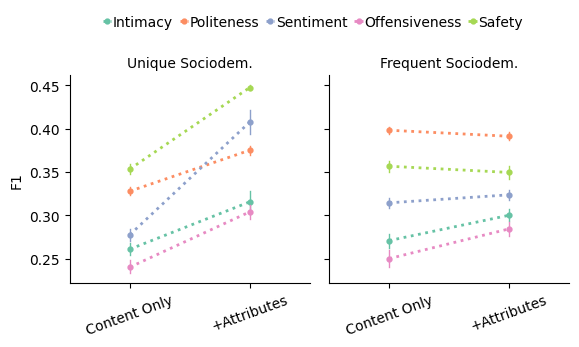

In [27]:
g = plot_combinations_frequency(combinations_plot_df)

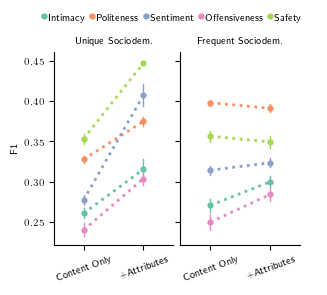

In [28]:
with plt.style.context("./fig/acl.mplstyle"):
    g = plot_combinations_frequency(combinations_plot_df)
    g.figure.set_size_inches(3.25, 2.5)
    plt.savefig(
        'fig/analysis_socdem_v2.pgf',
        dpi=300
    )


# Disaggregated F-Scores

In [29]:
from multi_annotator.utils import map_letter_labels_to_numeric, task_to_scale_max
def get_classification_reports(task='diaz', seed='536804', split='instance'):
    best_lrs = {
        'diaz': ('3e-05','6e-05','6e-05'),
        'offensiveness': ('3e-05','8e-05','8e-05'),
        'intimacy': ('6e-05','6e-05','6e-05'),
        'politeness': ('8e-05','8e-05','8e-05'),
    }
    scale_max = task_to_scale_max('task')
    lrs = best_lrs[task]
    zero_shot = pd.read_csv(f'../../data/out/llama3_instruct/536804-llama3_instruct-{task}-notokens-instance-0.0003-prompt.csv')
    zero_shot['prediction'] = zero_shot['generation'].apply(map_letter_labels_to_numeric, scale_1_to=scale_max)
    notokens = pd.read_csv(f'../../data/out/llama3_classification/536804-llama3_classification-{task}-notokens-instance-{lrs[0]}.csv')
    attributes = pd.read_csv(f'../../data/out/llama3_classification/536804-llama3_classification-{task}-textual-instance-{lrs[1]}.csv')
    annotator_id = pd.read_csv(f'../../data/out/llama3_classification/536804-llama3_classification-{task}-textual_id-instance-{lrs[2]}.csv')
    print('Zero-Shot - Content') 
    print(classification_report(zero_shot['label'].astype('str'), zero_shot['prediction'].astype('str')))
    print('Content')    
    print(classification_report(notokens['label'], notokens['prediction']))
    print('Content+Attributes')    
    print(classification_report(attributes['label'], attributes['prediction']))
    print('Content+ID') 
    print(classification_report(annotator_id['label'], annotator_id['prediction']))


In [30]:
def get_f_scores(task='diaz', seed='536804', split='instance'):
    best_lrs = {
        'diaz': ('3e-05','6e-05','6e-05'),
        'offensiveness': ('3e-05','8e-05','8e-05'),
        'intimacy': ('6e-05','6e-05','6e-05'),
        'politeness': ('8e-05','8e-05','8e-05'),
    }
    lrs = best_lrs[task]
    notokens = pd.read_csv(f'../../data/out/llama3_classification/536804-llama3_classification-{task}-notokens-instance-{lrs[0]}.csv')
    attributes = pd.read_csv(f'../../data/out/llama3_classification/536804-llama3_classification-{task}-textual-instance-{lrs[1]}.csv')
    annotator_id = pd.read_csv(f'../../data/out/llama3_classification/536804-llama3_classification-{task}-textual_id-instance-{lrs[2]}.csv')
    print('Content')    
    print(classification_report(notokens['label'], notokens['prediction']))
    print('Content+Attributes')    
    print(classification_report(attributes['label'], attributes['prediction']))
    print('Content+ID') 
    print(classification_report(annotator_id['label'], annotator_id['prediction']))

In [31]:
get_classification_reports(task='intimacy')

Zero-Shot - Content
              precision    recall  f1-score   support

         0.0       0.58      0.17      0.26      1191
        0.25       0.20      0.75      0.32       464
         0.5       0.24      0.06      0.10       387
        0.75       0.22      0.14      0.17       300
         1.0       0.25      0.17      0.20       148

    accuracy                           0.26      2490
   macro avg       0.30      0.26      0.21      2490
weighted avg       0.39      0.26      0.23      2490

Content
              precision    recall  f1-score   support

           0       0.54      0.77      0.63      1191
           1       0.17      0.11      0.14       464
           2       0.21      0.11      0.15       387
           3       0.22      0.14      0.17       300
           4       0.38      0.19      0.25       148

    accuracy                           0.43      2490
   macro avg       0.30      0.26      0.27      2490
weighted avg       0.37      0.43      0.39      

In [32]:
get_classification_reports(task='diaz')

Zero-Shot - Content
              precision    recall  f1-score   support

         0.0       0.15      0.40      0.22       571
        0.25       0.26      0.54      0.35      2285
         0.5       0.58      0.05      0.09      5185
        0.75       0.33      0.49      0.40      2881
         1.0       0.27      0.30      0.29      1211

    accuracy                           0.29     12133
   macro avg       0.32      0.35      0.27     12133
weighted avg       0.41      0.29      0.24     12133

Content
              precision    recall  f1-score   support

           0       0.33      0.11      0.17       571
           1       0.39      0.34      0.36      2285
           2       0.49      0.64      0.56      5185
           3       0.39      0.37      0.38      2881
           4       0.37      0.13      0.19      1211

    accuracy                           0.44     12133
   macro avg       0.39      0.32      0.33     12133
weighted avg       0.43      0.44      0.42     1

In [33]:
get_classification_reports(task='politeness')

Zero-Shot - Content
              precision    recall  f1-score   support

         0.0       0.34      0.72      0.46       579
        0.25       0.17      0.40      0.24       709
         0.5       0.30      0.24      0.27      1509
        0.75       0.32      0.20      0.24      1198
         1.0       0.70      0.10      0.17      1004

    accuracy                           0.28      4999
   macro avg       0.36      0.33      0.28      4999
weighted avg       0.37      0.28      0.26      4999

Content
              precision    recall  f1-score   support

           0       0.45      0.38      0.41       579
           1       0.27      0.16      0.20       709
           2       0.42      0.49      0.45      1509
           3       0.33      0.36      0.35      1198
           4       0.48      0.49      0.48      1004

    accuracy                           0.40      4999
   macro avg       0.39      0.37      0.38      4999
weighted avg       0.39      0.40      0.39      

In [34]:
get_classification_reports(task='offensiveness')

Zero-Shot - Content
              precision    recall  f1-score   support

         0.0       0.82      0.41      0.54      1556
        0.25       0.18      0.18      0.18       434
         0.5       0.12      0.22      0.15       305
        0.75       0.11      0.19      0.13       209
         1.0       0.16      0.64      0.25       106

    accuracy                           0.34      2610
   macro avg       0.27      0.33      0.25      2610
weighted avg       0.54      0.34      0.39      2610

Content
              precision    recall  f1-score   support

           0       0.65      0.75      0.70      1556
           1       0.14      0.10      0.12       434
           2       0.16      0.16      0.16       305
           3       0.14      0.06      0.09       209
           4       0.09      0.08      0.09       106

    accuracy                           0.49      2610
   macro avg       0.24      0.23      0.23      2610
weighted avg       0.44      0.49      0.46      

# Per instance calculate difference to label distribution

In [35]:
def calc_distance(row, column='label', prediction_distribution=None, n_labels=5):
    if not prediction_distribution:
        prediction_distribution = row['prediction']
    if n_labels == 5:
        label_cats = [0,1,2,3,4]
    elif n_labels == 3:
        label_cats = [0,1,2]
    return wasserstein_distance(
        label_cats,
        label_cats, 
        row[column], 
        prediction_distribution
    )

def to_label_distribution(labels, n_labels=5):
    if n_labels == 5:
        label_cats = [0,1,2,3,4]
    elif n_labels == 3:
        label_cats = [0,1,2]
    else:
        raise ValueError('n_labels has to be 3 or 5')
    l = pd.Series(pd.Categorical(labels, categories=label_cats))
    dist = l.value_counts(normalize=True, sort=False)
    return dist.tolist()

def label_distribution_to_majority_distribution(label_distribution):
    majority_label = pd.Series(label_distribution).argmax()
    distribution = [0.0] * len(label_distribution)
    distribution[majority_label] = 1.0
    return distribution


def get_instances_df(attributes='no', task='diaz', split='instance'):
    #df = get_mean_run_results(task=task, attributes=attributes, split=split)
    df = get_results(task=task, attributes=attributes, split=split)
    instances = df.groupby(['instance_id', 'seed'])[['label', 'prediction']].agg(lambda x : to_label_distribution(x, n_labels=3 if 'dices' in task.lower() else 5))
    return instances

def get_distances(instances: pd.DataFrame, label_distribution_distance=None):
    # tie breaking by taking the first value
    instances['majority'] = instances['label'].apply(label_distribution_to_majority_distribution)
    instances['label_distance'] = instances.apply(calc_distance, axis=1)
    instances['majority_distance'] = instances.apply(calc_distance, column='majority', axis=1)

    if label_distribution_distance == 'bimodal_distance':
        instances['bimodal_distance'] = instances.apply(calc_distance, column='label', prediction_distribution=[0.5, 0.0, 0.0, 0.0, 0.5], axis=1)
    elif label_distribution_distance == '2_distance':
        instances['2_distance'] = instances.apply(calc_distance, column='label', prediction_distribution=[0.0, 0.0, 1.0, 0.0, 0.0], axis=1)
    elif label_distribution_distance == '0_distance':
        instances['0_distance'] = instances.apply(calc_distance, column='label', prediction_distribution=[0.1, 0.0, 0.0, 0.0, 0.0], axis=1)
    elif label_distribution_distance == '4_distance':
        instances['4_distance'] = instances.apply(calc_distance, column='label', prediction_distribution=[0.0, 0.0, 0.0, 0.0, 1.0], axis=1)
    elif label_distribution_distance == 'uniform_distance':
        instances['uniform_distance'] = instances.apply(calc_distance, column='label', prediction_distribution=[0.2, 0.2, 0.2, 0.2, 0.2], axis=1)

    return instances

def get_agreement_types_df(task, split='instance'):
    df_no = get_instances_df(attributes='no', task=task, split=split)
    df_no['attributes'] = 'Content Only'
    df_attr = get_instances_df(attributes='attributes', task=task, split=split)
    df_attr['attributes'] = '+Attributes'
    df_id = get_instances_df(attributes='id', task=task, split=split)
    df_id['attributes'] = '+ID'
    all_instances = [df_no, df_attr, df_id]

    distribution_types = [
        ('uniform_distance', .4, 'Disagreement:\nUniform'),
        ('bimodal_distance', .6, 'Disagreement:\nBimodal'), 
        #('0_distance', .25, 'Agreement: Lowest Rating'),
        ('2_distance', .0, 'Agreement:\nMedium Rating'),
        ('4_distance', .25, 'Agreement:\nHighest Rating')
    ]

    dfs = []
    for label_distribution_distance, filter_value, desc in distribution_types:
        for instances in all_instances:
            distances = get_distances(instances, label_distribution_distance=label_distribution_distance)
            distances = distances[distances[label_distribution_distance] <= filter_value].copy()
            distances['agreement'] = f'{desc} (N={len(distances.index)})'
            dfs.append(distances)
    return pd.concat(dfs).reset_index()

In [36]:
def plot_label_distribution(df):
    palette = sns.color_palette("Paired")
    palette = [
        palette[1], 
        palette[5],
        palette[7]
    ]
    g = sns.FacetGrid(df, col='agreement', despine=True)
    g.map_dataframe(
        sns.pointplot, 
        x="attributes", 
        y="label_distance", 
        linestyles=':',
        hue='attributes', 
        #color='#66c2a5', # first color of Set2 palette
        palette=palette,
        hue_order=['Content Only', '+Attributes', '+ID'], 
        order=['Content Only', '+Attributes', '+ID'],
        errorbar=('ci', 95),
        n_boot = 10_000,
        seed=4242424242,
        markersize=4,
        err_kws={'linewidth': 1}
    )
    g.set_axis_labels('', 'distance to ratings')
    g.tick_params(axis='x', rotation=20)
    g.set_titles('{col_name}')
    return g

In [37]:
def get_entropies(tasks=['diaz', 'dices-350', 'intimacy', 'offensiveness', 'politeness']):
    dfs = []
    for task in tasks:
        for attr in ['no', 'attributes', 'id']:
            instances = get_instances_df(task=task, attributes=attr)
            n_labels = 3 if task == 'dices-350' else 5
            instances['distance'] = instances.apply(calc_distance, n_labels=n_labels, axis=1)
            instances['label_entropy'] = instances['label'].apply(lambda label_dist: entropy(label_dist))
            if attr == 'no':
                instances['attribute'] = 'Content-Only'
            elif attr == 'attributes':
                instances['attribute'] = '+Attributes'
            elif attr == 'id':
                instances['attribute'] = '+ID'
            else:
                raise ValueError()
        
            if task == 'dices-350':
                task_name = 'Safety'
            elif task == 'diaz':
                task_name = 'Sentiment'
            else:
                task_name = task.title()
            instances['task'] = task_name
            median_ent = instances['label_entropy'].median()
            instances['entropy_level'] = instances['label_entropy'].apply(lambda ent: 'Higher Label Entropy' if ent > median_ent else 'Lower Label Entropy')
            dfs.append(instances)
    df = pd.concat(dfs).reset_index()
    return df

In [38]:
dff = get_entropies(tasks=['intimacy'])

In [39]:
dff.groupby(['task', 'attribute', 'entropy_level'])['distance'].describe()

count      mean       std  min  \
task     attribute    entropy_level                                           
Intimacy +Attributes  Higher Label Entropy  5820.0  1.024852  0.451915  0.0   
                      Lower Label Entropy   6150.0  0.493483  0.440742  0.0   
         +ID          Higher Label Entropy  5820.0  0.606873  0.332178  0.0   
                      Lower Label Entropy   6150.0  0.375809  0.361078  0.0   
         Content-Only Higher Label Entropy  5820.0  1.339712  0.463760  0.5   
                      Lower Label Entropy   6150.0  0.591050  0.553217  0.0   

                                                 25%       50%       75%  \
task     attribute    entropy_level                                        
Intimacy +Attributes  Higher Label Entropy  0.714286  1.000000  1.285714   
                      Lower Label Entropy   0.166667  0.428571  0.714286   
         +ID          Higher Label Entropy  0.333333  0.571429  0.833333   
                      Lower Label Entropy   0.142857  0.285714  0.500000   
         Content-Only Higher Label Entropy  1.000000  1.285714  1.666667   
                      Lower Label Entropy   0.200000  0.500000  0.833333   

                                                 max  
task     attribute    entropy_level                   
Intimacy +Attributes  Higher Label Entropy  2.833333  
                      Lower Label Entropy   4.000000  
         +ID          Higher Label Entropy  2.166667  
                      Lower Label Entropy   3.166667  
         Content-Only Higher Label Entropy  3.142857  
                      Lower Label Entropy   4.000000

In [40]:
def plot_distance_per_entropy_level(df, group_seeds=True):
    if group_seeds:
        # for mean calculation there is no difference to directly computing the overall score
        # but changes variance relevant in bootstrap sampling
        df = df.groupby(['task', 'seed', 'attribute', 'entropy_level'])[['distance']].mean().reset_index()
    with sns.axes_style("whitegrid", {"grid.color": ".9", "grid.linestyle": "--"}):
        g = sns.FacetGrid(df, col='task', despine=True)
        g.map_dataframe(
            sns.pointplot, 
            x="attribute",
            order=['Content-Only', '+Attributes', '+ID'], 
            y="distance", 
            linestyles=':',
            linewidth=1,
            palette=sns.color_palette("Set2"),
            hue='entropy_level',
            hue_order=['Lower Label Entropy', 'Higher Label Entropy'],
            errorbar=('ci', 99),
            n_boot = 10_000,
            seed=4242424242,
            markersize=3,
            err_kws={'linewidth': 1}
        )
    g.set_axis_labels('', 'distance to ratings')
    g.tick_params(axis='x', rotation=20)
    g.set_titles('{col_name}')
    g.add_legend()
    sns.move_legend(
        g, 
        "lower center",
        bbox_to_anchor=(0.45, 1), ncol=2, title=None, frameon=False,
    )

    return g

In [41]:
df_ent = get_entropies(tasks=['diaz', 'dices-350', 'intimacy', 'offensiveness', 'politeness'])

In [42]:
correlations = df_ent.groupby(['task', 'attribute', 'seed']).apply(lambda group: pearsonr(group['label_entropy'], group['distance']).statistic)
correlations.name = 'pearson r'
correlations_df = correlations.to_frame().reset_index()

In [43]:
correlations_df.groupby(['task', 'attribute'])['pearson r'].describe()

count      mean       std       min       25%  \
task          attribute                                                     
Intimacy      +Attributes    30.0  0.625380  0.033574  0.536087  0.603090   
              +ID            30.0  0.386503  0.037734  0.290384  0.355169   
              Content-Only   30.0  0.687908  0.052517  0.571821  0.657462   
Offensiveness +Attributes    30.0  0.682481  0.037835  0.574326  0.653230   
              +ID            30.0  0.532260  0.036609  0.456142  0.507654   
              Content-Only   30.0  0.628727  0.054925  0.489721  0.601981   
Politeness    +Attributes    30.0  0.408783  0.027752  0.360127  0.388653   
              +ID            30.0  0.226135  0.027972  0.148289  0.212258   
              Content-Only   30.0  0.519478  0.027058  0.458815  0.504577   
Safety        +Attributes    30.0  0.371460  0.087884  0.207879  0.324351   
              +ID            30.0  0.274845  0.119495  0.017619  0.200798   
              Content-Only   30.0  0.536715  0.097956  0.345622  0.483170   
Sentiment     +Attributes    30.0  0.384813  0.019660  0.347694  0.369583   
              +ID            30.0  0.188398  0.016200  0.159748  0.174318   
              Content-Only   30.0  0.502508  0.015096  0.477568  0.493131   

                                 50%       75%       max  
task          attribute                                   
Intimacy      +Attributes   0.628330  0.645096  0.685728  
              +ID           0.388269  0.414615  0.441512  
              Content-Only  0.698938  0.728992  0.764880  
Offensiveness +Attributes   0.687561  0.712772  0.756014  
              +ID           0.533293  0.558391  0.610530  
              Content-Only  0.636323  0.664634  0.725652  
Politeness    +Attributes   0.406713  0.424149  0.470035  
              +ID           0.229422  0.245905  0.272165  
              Content-Only  0.524393  0.539680  0.567820  
Safety        +Attributes   0.362493  0.434849  0.520634  
              +ID           0.277442  0.372353  0.484238  
              Content-Only  0.534204  0.586227  0.711091  
Sentiment     +Attributes   0.382514  0.401297  0.421828  
              +ID           0.187703  0.199035  0.215459  
              Content-Only  0.498017  0.508109  0.539029

In [44]:
def plot_correlations(correlations_df):
    with sns.axes_style("whitegrid", {"grid.color": ".9", "grid.linestyle": "--"}):
        ax = sns.pointplot(
            data=correlations_df,
            palette='Set2',
            linestyles=':',
            linewidth=1,
            x='attribute',
            order=['Content-Only', '+Attributes', '+ID'], 
            y='pearson r',
            hue='task',
            errorbar=('ci', 95),
            n_boot = 10_000,
            seed=4242424242,
            markersize=4,
            err_kws={'linewidth': 1}
        )
        sns.despine()
        sns.move_legend(
            ax, 
            "lower center",
            bbox_to_anchor=(0.45, 1), ncol=3, title=None, frameon=False,
        )
        ax.set_xlabel('')
        ax.set_ylabel("Pearson's r")
        return ax

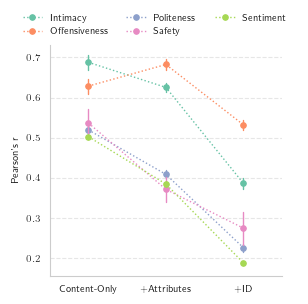

In [45]:
with plt.style.context("./fig/acl.mplstyle"):
    ax = plot_correlations(correlations_df)
    ax.figure.set_size_inches(3, 3)
    plt.savefig(
        'fig/analysis_disagreement_correlation.pgf',
        dpi=300
    )

In [46]:
df_temp = df_ent.groupby(['task', 'attribute', 'entropy_level', 'seed'])[['distance']].mean().reset_index()

In [47]:
df_ent.groupby(['task', 'attribute', 'entropy_level'])[['distance']].describe().head(6)

distance                           \
                                              count      mean       std  min   
task     attribute    entropy_level                                            
Intimacy +Attributes  Higher Label Entropy   5820.0  1.024852  0.451915  0.0   
                      Lower Label Entropy    6150.0  0.493483  0.440742  0.0   
         +ID          Higher Label Entropy   5820.0  0.606873  0.332178  0.0   
                      Lower Label Entropy    6150.0  0.375809  0.361078  0.0   
         Content-Only Higher Label Entropy   5820.0  1.339712  0.463760  0.5   
                      Lower Label Entropy    6150.0  0.591050  0.553217  0.0   

                                                                          \
                                                 25%       50%       75%   
task     attribute    entropy_level                                        
Intimacy +Attributes  Higher Label Entropy  0.714286  1.000000  1.285714   
                      Lower Label Entropy   0.166667  0.428571  0.714286   
         +ID          Higher Label Entropy  0.333333  0.571429  0.833333   
                      Lower Label Entropy   0.142857  0.285714  0.500000   
         Content-Only Higher Label Entropy  1.000000  1.285714  1.666667   
                      Lower Label Entropy   0.200000  0.500000  0.833333   

                                                      
                                                 max  
task     attribute    entropy_level                   
Intimacy +Attributes  Higher Label Entropy  2.833333  
                      Lower Label Entropy   4.000000  
         +ID          Higher Label Entropy  2.166667  
                      Lower Label Entropy   3.166667  
         Content-Only Higher Label Entropy  3.142857  
                      Lower Label Entropy   4.000000

In [48]:
df_temp.groupby(['task', 'attribute', 'entropy_level'])[['distance']].describe().head(6)

distance                      \
                                              count      mean       std   
task     attribute    entropy_level                                       
Intimacy +Attributes  Higher Label Entropy     30.0  1.024852  0.043255   
                      Lower Label Entropy      30.0  0.493483  0.025980   
         +ID          Higher Label Entropy     30.0  0.606873  0.023217   
                      Lower Label Entropy      30.0  0.375809  0.018981   
         Content-Only Higher Label Entropy     30.0  1.339712  0.021112   
                      Lower Label Entropy      30.0  0.591050  0.042386   

                                                                          \
                                                 min       25%       50%   
task     attribute    entropy_level                                        
Intimacy +Attributes  Higher Label Entropy  0.937739  0.994094  1.029964   
                      Lower Label Entropy   0.443031  0.477654  0.486551   
         +ID          Higher Label Entropy  0.540660  0.591452  0.606591   
                      Lower Label Entropy   0.346643  0.361521  0.370749   
         Content-Only Higher Label Entropy  1.293716  1.327399  1.336770   
                      Lower Label Entropy   0.530337  0.559082  0.582439   

                                                                
                                                 75%       max  
task     attribute    entropy_level                             
Intimacy +Attributes  Higher Label Entropy  1.052099  1.093459  
                      Lower Label Entropy   0.510009  0.546504  
         +ID          Higher Label Entropy  0.625592  0.649963  
                      Lower Label Entropy   0.389623  0.421347  
         Content-Only Higher Label Entropy  1.351859  1.382204  
                      Lower Label Entropy   0.619849  0.696307

/home/matthias/development/multi-annotator/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/matthias/development/multi-annotator/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/matthias/development/multi-annotator/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/matthias/development/multi-annotator/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/matthias/development/multi-annotator/.venv/lib/python3.9/site-packages/sea

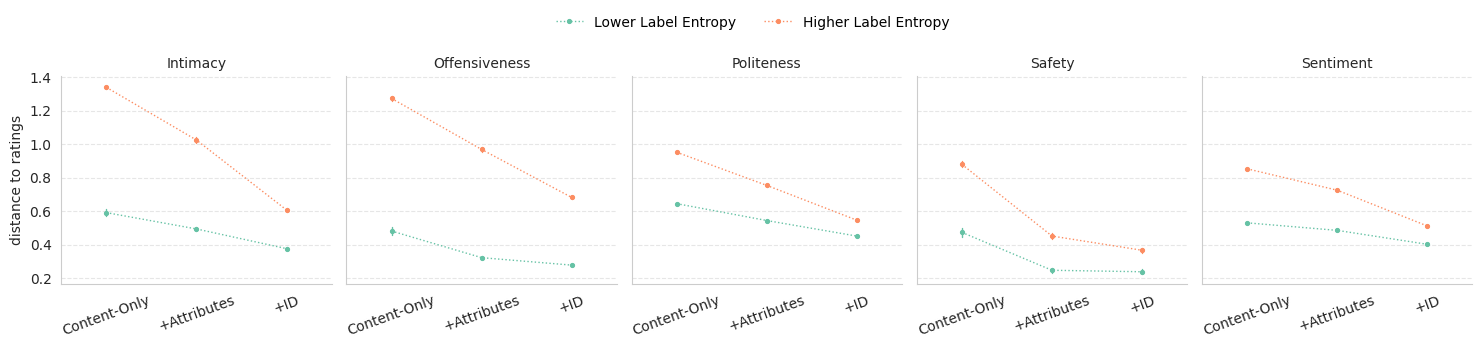

In [49]:
plot_distance_per_entropy_level(df_ent, group_seeds=True)

In [50]:
df_ent.to_csv('fig/entropy_levels_and_distances.csv')

/home/matthias/development/multi-annotator/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/matthias/development/multi-annotator/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/matthias/development/multi-annotator/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/matthias/development/multi-annotator/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/matthias/development/multi-annotator/.venv/lib/python3.9/site-packages/sea

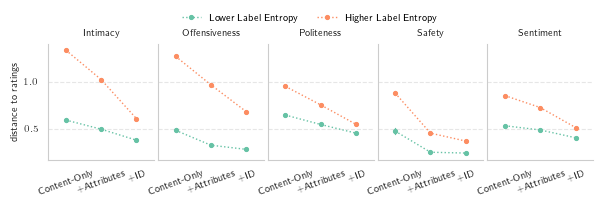

In [51]:
with plt.style.context("./fig/acl.mplstyle"):
    g = plot_distance_per_entropy_level(df_ent, group_seeds=True)
    g.figure.set_size_inches(6.25, 1.5)
    plt.savefig(
        'fig/analysis_disagreement_v3.pgf',
        dpi=300
    )

In [52]:
df = get_agreement_types_df('diaz')

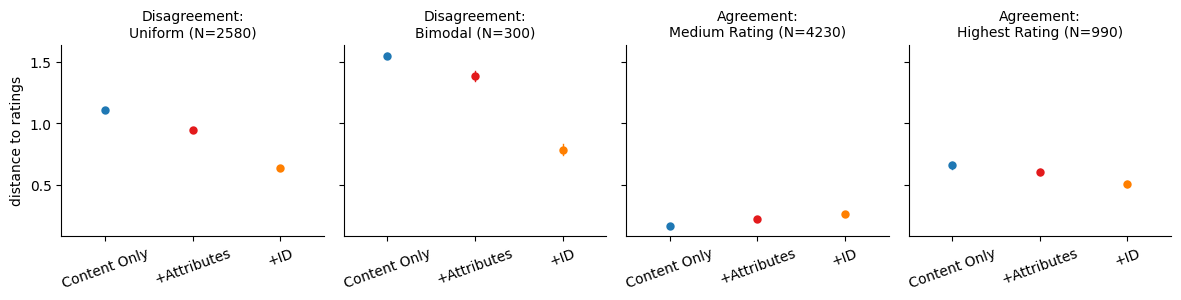

In [53]:
plot_label_distribution(df)

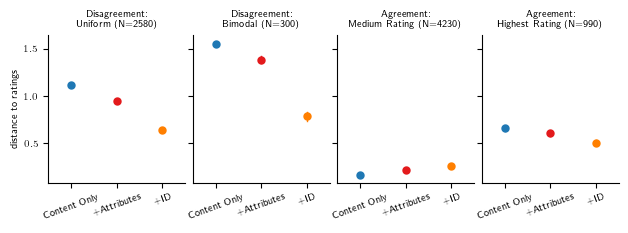

In [54]:
with plt.style.context("./fig/acl.mplstyle"):
    g = plot_label_distribution(df)
    g.figure.set_size_inches(6, 2)
    plt.savefig(
        'fig/analysis_disagreement.pgf',
        dpi=300
    )